In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
import requests
from selenium import webdriver
import re
import time
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy as sp
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
pd.set_option('display.max_columns', 30)

In [4]:
seasons = ['1996-97', '1997-98', '1999-00', '2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08',
            '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19']

In [5]:
def get_data(seasons_list):
    statistics = pd.DataFrame()
    for season in seasons_list:
        url = 'https://stats.nba.com/teams/traditional/?sort=W_PCT&dir=-1&Season=' + season + '&SeasonType=Regular%20Season'
        driver = webdriver.Chrome(r"/Users/Robert/Downloads/chromedriver")
        driver.get(url)
        time.sleep(3)
        table = driver.find_element_by_class_name('nba-stat-table__overflow')
        remove_endline = table.text.split('\n')
        row_to_string = ' '.join(remove_endline)
        split_lines = re.sub(r'\s\d{1,2}\s([A-Z])', r'\n\1', row_to_string)
        separate_teams = split_lines.split('\n')
        table_list = []
        for row in separate_teams:
            split_stats = row.split()
            table_list.append(split_stats[-27:])
        df = pd.DataFrame.from_records(table_list[1:], columns = table_list[0])
        df.insert(0, 'SEASON', season)
        statistics = pd.concat([statistics, df], ignore_index = True)
        driver.close()
    return statistics

In [6]:
# statistics_df = get_data(seasons)

In [8]:
# statistics_df
# statistics_df.to_csv('nba_statistics_pergame.csv', index=False)

In [9]:
# Load dataframe and edit column names since numbers in the names, as well as percent signs and + and - don't work well with Python
stats_df = pd.read_csv('nba_statistics_pergame.csv')
stats_df.rename(columns = {'WIN%' : 'WIN_PERCENT', 'FG%': 'FG_PERCENT', '3PM': 'THREE_PM', '3PA': 'THREE_PA', '3P%': 'THREE_P_PERCENT', 'FT%': 'FT_PERCENT', '+/-' : 'PLUS_MINUS'}, inplace=True)

stats_df

,SEASON,TEAM,GP,W,L,WIN_PERCENT,MIN,PTS,FGM,FGA,FG_PERCENT,THREE_PM,THREE_PA,THREE_P_PERCENT,FTM,FTA,FT_PERCENT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PLUS_MINUS
0,1996-97,Bulls,82,69,13,0.841,48.1,103.1,40.0,84.4,47.3,6.4,17.1,37.3,16.8,22.5,74.7,15.1,30.0,45.1,26.1,13.5,8.7,4.0,3.5,19.7,0.2,10.8
1,1996-97,Jazz,82,64,18,0.780,48.4,103.1,38.2,75.8,50.4,4.1,11.0,37.0,22.7,29.5,76.9,10.8,29.4,40.2,26.8,15.4,9.1,5.1,4.5,24.1,0.2,8.8
2,1996-97,Heat,82,61,21,0.744,48.3,94.8,34.4,76.0,45.3,8.3,22.7,36.4,17.7,24.7,71.9,11.7,29.3,41.0,21.2,15.9,7.9,5.4,4.8,23.4,0.3,5.5
3,1996-97,Rockets,82,57,25,0.695,48.4,100.6,37.0,79.1,46.8,8.2,22.4,36.5,18.3,24.3,75.5,11.3,31.3,42.6,24.5,16.6,8.4,4.2,4.5,19.6,0.2,4.5
4,1996-97,Knicks,82,57,25,0.695,48.4,95.4,35.1,75.9,46.3,5.7,15.8,36.3,19.3,25.8,74.8,11.9,30.7,42.5,22.1,17.8,7.7,4.6,3.6,24.8,0.2,3.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,2018-19,Hawks,82,29,53,0.354,48.4,113.3,41.4,91.8,45.1,13.0,37.0,35.2,17.6,23.4,75.2,11.6,34.5,46.1,25.8,17.0,8.2,5.1,5.5,23.6,22.2,-6.0
649,2018-19,Bulls,82,22,60,0.268,48.5,104.9,39.8,87.9,45.3,9.1,25.9,35.1,16.2,20.7,78.3,8.8,34.1,42.9,21.9,14.1,7.4,4.3,5.8,20.3,18.7,-8.4
650,2018-19,Cavaliers,82,19,63,0.232,48.2,104.5,38.9,87.6,44.4,10.3,29.1,35.5,16.4,20.7,79.2,10.7,31.9,42.7,20.7,13.5,6.5,2.4,5.6,20.0,19.4,-9.6
651,2018-19,Suns,82,19,63,0.232,48.5,107.5,40.1,87.4,45.9,9.6,29.3,32.9,17.6,22.7,77.9,9.1,31.3,40.4,23.9,15.6,9.0,5.1,5.0,23.6,20.7,-9.3


In [10]:
outcome = 'WIN_PERCENT'
x_cols = ['PTS', 'FGM', 'FGA', 'FG_PERCENT', 'THREE_PM', 'THREE_PA', 'THREE_P_PERCENT', 'FTM', 'FTA', 'FT_PERCENT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF']
log_cols = ['PTS', 'FGM', 'FG_PERCENT', 'THREE_PM', 'THREE_PA', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'BLK', 'BLKA']

In [ ]:
for cols in stats_df[log_cols]:
    stats_df[cols] = np.log(stats_df[cols])
stats_df

In [11]:
for col in stats_df[x_cols]:
    stats_df[col] = (stats_df[col] - stats_df[col].mean())/stats_df[col].std()
stats_df

,SEASON,TEAM,GP,W,L,WIN_PERCENT,MIN,PTS,FGM,FGA,FG_PERCENT,THREE_PM,THREE_PA,THREE_P_PERCENT,FTM,FTA,FT_PERCENT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PLUS_MINUS
0,1996-97,Bulls,82,69,13,0.841,48.1,0.661181,1.398774,0.689873,1.292252,-0.155664,-0.304650,0.924529,-0.770398,-0.666564,-0.291215,2.616724,-0.472017,1.399794,2.114828,-0.920094,1.147480,-1.102186,-1.988845,-0.861537,0.2,10.8
1,1996-97,Jazz,82,64,18,0.780,48.4,0.661181,0.532308,-1.762144,3.246608,-1.148831,-1.287728,0.776293,2.258287,2.004017,0.456256,-0.382255,-0.756054,-1.087942,2.465993,0.656429,1.592634,0.211839,-0.591926,1.627271,0.2,8.8
2,1996-97,Heat,82,61,21,0.744,48.3,-0.766294,-1.296897,-1.705121,0.031377,0.664779,0.597848,0.479820,-0.308395,0.172761,-1.242542,0.245438,-0.803393,-0.681781,-0.343329,1.071304,0.257173,0.570210,-0.172850,1.231324,0.3,5.5
3,1996-97,Rockets,82,57,25,0.695,48.4,0.231218,-0.045336,-0.821254,0.977033,0.621597,0.549500,0.529232,-0.000393,0.020156,-0.019407,-0.033537,0.143396,0.130541,1.312164,1.652129,0.813615,-0.863272,-0.591926,-0.918101,0.2,4.5
4,1996-97,Knicks,82,57,25,0.695,48.4,-0.663103,-0.959938,-1.733632,0.661814,-0.457932,-0.514158,0.430408,0.512943,0.592424,-0.257239,0.384925,-0.140641,0.079771,0.108169,2.647828,0.034597,-0.385445,-1.849153,2.023217,0.2,3.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,2018-19,Hawks,82,29,53,0.354,48.4,2.415428,2.072692,2.799748,-0.094710,2.694294,2.902441,-0.113126,-0.359729,-0.323204,-0.121335,0.175694,1.658258,1.907495,1.964328,1.984028,0.591038,0.211839,0.804993,1.344452,22.2,-6.0
649,2018-19,Bulls,82,22,60,0.268,48.5,0.970754,1.302500,1.687786,0.031377,1.010228,1.113561,-0.162538,-1.078399,-1.353285,0.931920,-1.777129,1.468900,0.282851,0.007836,-0.422245,-0.299269,-0.743816,1.224069,-0.522154,18.7,-8.4
650,2018-19,Cavaliers,82,19,63,0.232,48.2,0.901960,0.869267,1.602251,-0.536017,1.528402,1.629274,0.035111,-0.975732,-1.353285,1.237703,-0.451999,0.427432,0.181311,-0.594161,-0.920094,-1.300864,-3.013496,0.944685,-0.691846,19.4,-9.6
651,2018-19,Suns,82,19,63,0.232,48.5,1.417915,1.446911,1.545227,0.409639,1.226134,1.661506,-1.249605,-0.359729,-0.590262,0.796016,-1.567898,0.143396,-0.986402,1.011165,0.822379,1.481345,0.211839,0.106534,1.344452,20.7,-9.3


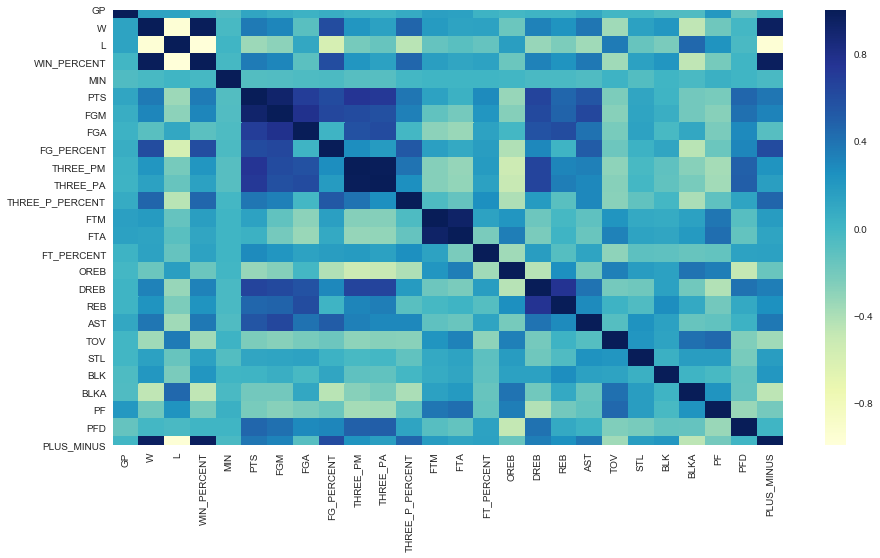

In [14]:
plt.figure(figsize = (15,8))
sns.heatmap(stats_df.corr(), cmap="YlGnBu")